<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Multilabel Classification

In this notebook, we will look at the best practices for doing multilabel classification. 

In the previous notebook, we performed multi-class/single-label classification, which assumes that each image is assigned to only one label: an animal can be either an dog or a cat but not both at the same time. Multi-label classification on the other hand, will assume that each image can contain or represent multiple different labels: a landscape can be labeled both gloomy (weather) and of a beach (subject).

In this notebook, we'll train a multilabel classifier and examine how best to structure data for multilabel classification problems as well as learn about new ways to evaluate our results. 

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai and other libraries needed. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [2]:
import sys
sys.path.append("../../")

import warnings
warnings.filterwarnings('ignore')

import inspect
import numpy as np
import pandas as pd
from pathlib import Path

# fastai and torch
import fastai
from fastai.vision import *

# local modules
from utils_cv.classification.model import TrainMetricsRecorder, hamming_loss
from utils_cv.classification.plot import plot_pr_roc_curves, plot_hamming_loss_thresholds
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.47
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB
Available / Total memory = 16119 / 16130 (MiB)


Like before, we set some parameters. This time, we can use one of the multilabel datasets that comes with this repo.

In [3]:
DATA_PATH     = unzip_url(Urls.multilabel_fridge_objects_path, exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## 1. Preparing Image Data for Multilabel Classification

In this notebook, we'll look at different kinds of beverages. In the repo, under `data`, we've downloaded a directory titled: __multilabelFridgeObjects__.

Lets set that directory to our `path` variable, which we'll use throughout the notebook. We'll also inspect what's inside to get an understanding of how to structure images for multilabel classification.

In [4]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/models'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/labels.csv'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images')]

Lets inspect the `/images` folder:

In [5]:
(path/'images').ls()[:5]

[PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/16.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/98.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/66.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/76.jpg'),
 PosixPath('/home/jiata/code/cvbp/data/multilabelFridgeObjects/images/33.jpg')]

Lets also take a look at the `labels.csv` file using pandas. 

In [6]:
df = pd.read_csv(path/'labels.csv'); df.sample(5)

,filename,labels
11,12.jpg,carton water_bottle
14,15.jpg,milk_bottle can
74,75.jpg,carton can milk_bottle water_bottle
121,122.jpg,water_bottle milk_bottle
61,62.jpg,carton can milk_bottle water_bottle


As shown above, the contents of the csv file is a mapping of the filename to the labels. Since this is a multilabel classificaiton problem, each image can be associated to multiple labels.

This is one of the most common data formast for multilabel image classification; one csv file that contains the mapping of labels to a folder of images:

```
/images
+-- labels.csv
+-- images
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
|   +-- image131.jpg
|   +-- image132.jpg
```

## 2. Load labels and images

__Loading data__

Now that we know the structure of our data, lets use fast.ai's data block apis to create our databunches so that we can easily load mini-batches of data from our filesystem into our trainer.

In [7]:
np.random.seed(42)
data = (ImageList.from_csv(path, 'labels.csv', folder='images')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' ')
       .transform(size=299)
       .databunch(bs=32)
       .normalize(imagenet_stats))

Lets break down the code:

The first thing we need to do is to create an `ImageList`, and we'll do so by creating it from a csv file (`from_csv`). Then we want to do a random split (`random_split_by_pct`) so that we have our validation set. For this method, we've also set a random seed (`np.random.seed(42)`) so that our validation set is consistent. Finally we want to get our labels from the df (`label_from_df`) that comes from the csv file. Since our labels are space-seperated in the csv file, we want to specify that our labels will be delimited by a space (`label_delim=' '`). 

In the second part, we use the `ImageList` we created and apply a transformation on it (`transform`) so that all images are resized to 299X299. Then we turn it into a databunch, which is basically the kind of object fastai's trainer uses to load mini-batches of data. Finally we'll normalize the databunch (`normalize(imagenet_states)` to the imagenet parameters.

__Inpsect data__

To make sure our data is correctly loaded, lets print out the number of classes, and each of the class labels.

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 4
['can', 'carton', 'milk_bottle', 'water_bottle']


We can also call `batch_stats` on our databunch object to get a view on how the data is split between training and validation.

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton,milk_bottle,can,water_bottle,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Valid: LabelList (25 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton;can;milk_bottle,water_bottle;carton;milk_bottle,water_bottle;can,milk_bottle;water_bottle;can,can
Path: /home/jiata/code/cvbp/data/multilabelFridgeObjects;

Test: None>

Lets get a sample of what the data looks like.

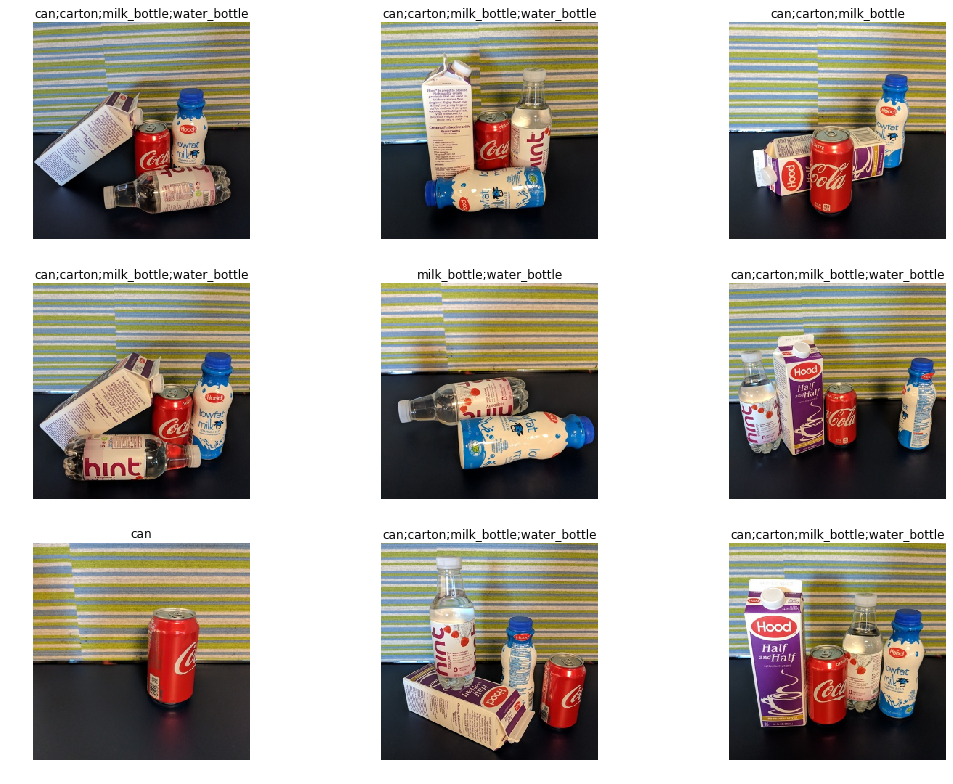

In [10]:
data.show_batch(rows=3, figsize=(15, 11))

## 3. Training our multilabel classifier

One of the main differences between training a multilabel classifier an a single-label classifier is how we may want to evaluate our model.

In a single-label (multi-class) classification model, we often use a model's accuracy to see how well a model performs.

However, for multilabel classification problems, a misclassification is not just a binary: right or wrong. Instead a prediction containing a subset of the labels we're looking for is better than one that contains none of them. For example, in an image that is labelled both 'rainy' and 'forest', it is better to predict one correct label than neither of the correct labels. A prediction that is faulty must also be penalized.

---

__Hamming Loss__

One of the most common ways to evaluate a multilabel classification problem is by using the Hamming loss, which we can think of as the fraction of wrong labels to the total number of labels. 

For example, lets our validation set contains 4 images and the results looks as such:
```
+-------+------------------+------------------+
| Image |  y_true:         |  y_pred:         |
|-------+------------------+------------------+
| im_01 |  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |
| im_02 |   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |
| im_03 |   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |
| im_04 |   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |
+-------+------------------+------------------+
```
In this case, the predictions has 3 out of a total of 16 predictions that are not true, so the hamming loss is __0.1875__.

While hamming loss is a common evaluation metric for multilabel classification, note that it may not be ideal for all multilabel classification problems. For each problem, you need to access what you're evaluating your model against to see if it is a good fit. 

---

If we want to take advantage of using Hamming Loss, we'll need to define our own evaluation metric. To do this, we'll need to create a custom function that will takes a `y_pred` and a `y_true`, and returns a single metric. 

> Since we've defined our hamming loss function in the `utils_cv.classification.models` module, lets just print out the function to see what it looks like.


In [11]:
print(inspect.getsource(hamming_loss))

def hamming_loss(y_pred:Tensor, y_true:Tensor, thresh:float=0.2,
        sigmoid:bool=True) -> float:
    """ Callback for using hamming loss as a evaluation metric. """
    if sigmoid: y_pred = y_pred.sigmoid()
    if thresh: y_pred = y_pred > thresh
    return (y_pred.float() != y_true).sum() / torch.ones(y_pred.shape).sum()



We'll use the `create_cnn` function to create our CNN, passing in our custom `hamming_loss` function.

In [12]:
learn = cnn_learner(
    data, 
    ARCHITECTURE, 
    metrics=[hamming_loss],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Unfreeze our CNN since we're training all the layers.

In [13]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

epoch,train_loss,valid_loss,train_hamming_loss,valid_hamming_loss,time
0,0.688325,0.657863,0.322917,0.380000,00:08
1,0.545509,0.595349,0.145833,0.350000,00:02
2,0.452289,0.539048,0.091146,0.230000,00:02
3,0.391489,0.496019,0.041667,0.200000,00:02
4,0.347333,0.470938,0.031250,0.140000,00:02
5,0.306091,0.419904,0.010417,0.100000,00:02
6,0.274643,0.368205,0.005208,0.100000,00:02
7,0.248730,0.332836,0.002604,0.090000,00:02
8,0.227347,0.306278,0.005208,0.080000,00:02
9,0.207207,0.270219,0.000000,0.080000,00:02


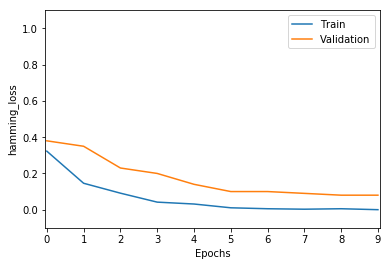

In [14]:
learn.fit(EPOCHS, LEARNING_RATE)

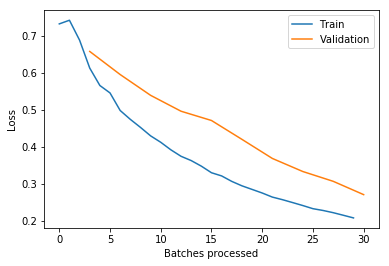

In [15]:
learn.recorder.plot_losses()

## 4. Evaluation the model

The learner comes with a handy function `show_results` that will show one mini-batch of the validation set. We can use that to get an intuitive sense of what is being predicted correctly and what is not.

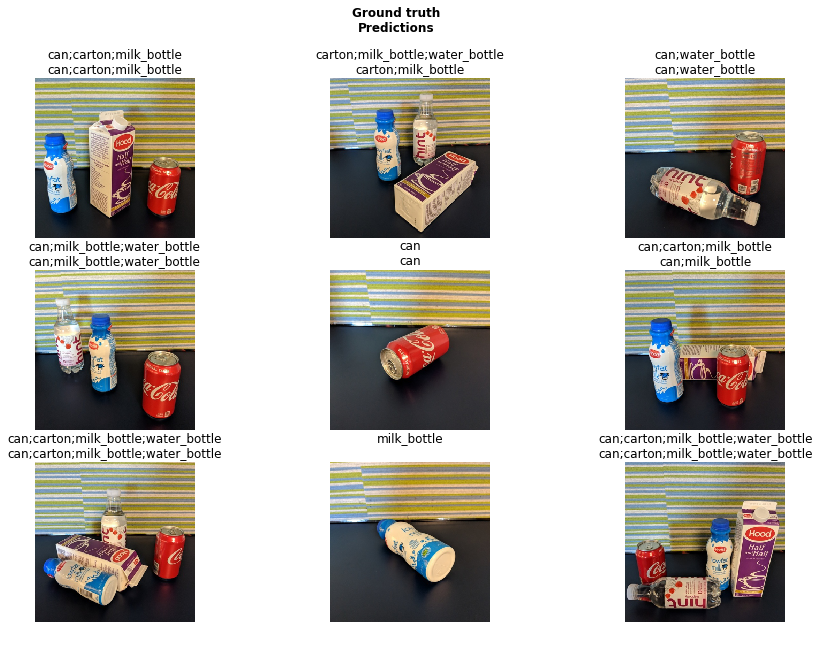

In [16]:
learn.show_results(rows=3, figsize=(15, 10))

To concretely evaluate our model, lets take a look at the hamming loss on the validation set. We can think of this value as the percentage of the total incorrect classifications out of the total possible classifications.

In [17]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[hamming_loss])
print(f'Hamming Loss on validation set: {float(metric):3.2f}')

Hamming Loss on validation set: 0.08


We've calculated the hamming loss on our validation set with the default probability threshold of 0.2. However, this default value may not be the most optimal value. We can use the `plot_hamming_loss_thresholds` function to plot the hamming loss at different probability thresholds. If the default threshold is far from the minimum, we may consider retraining the model with a new threshold.

When tweaking the threshold, note that the threshold represents a trade-off between specificity and sensitivity. The higher the threshold, the higher the specificity. The lower the threshold, the higher the sensivity.

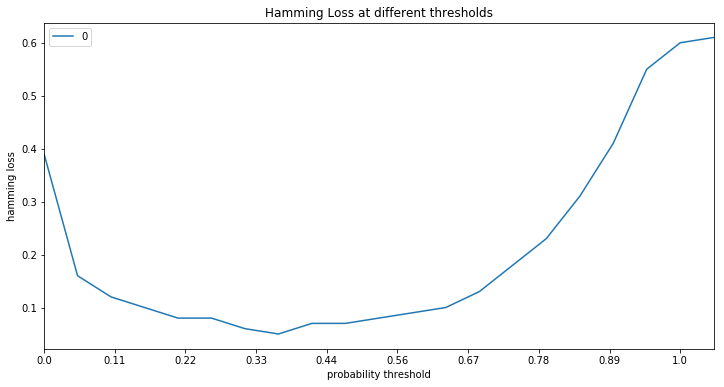

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
plot_hamming_loss_thresholds(interp)

Other than looking at hamming loss, we can also plot the recision-recall and ROC curves for each class. 

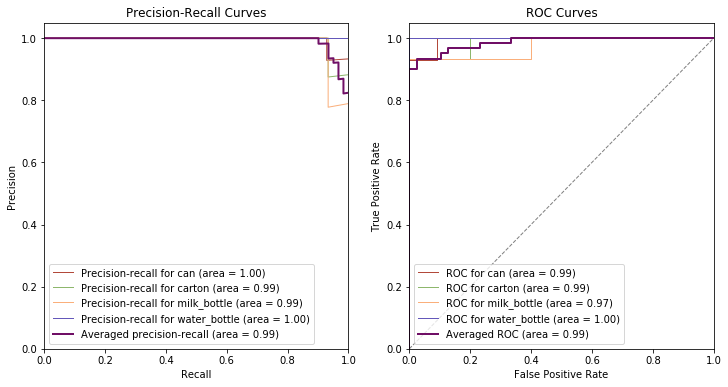

In [19]:
# True labels of the validation set. We convert to numpy array for plotting.
plot_pr_roc_curves(
    to_np(interp.y_true), 
    to_np(interp.probs), 
    data.classes
)